# Data Exploration

## Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

## Fashion Items

In [16]:
# Load in the data
df = pd.read_csv('../data/fashion_items.csv')
df.set_index('item_id', inplace=True)
df['tags'] = df['tags'].apply(ast.literal_eval)
df.head()

,title,tags,category
item_id,,,
0,Boho Summer Maxi Dress,"[boho, dress, summer]",dresses
1,Minimalist Linen Blouse,"[minimalist, blouse, neutrals]",tops
2,Vintage Denim Jacket,"[vintage, jacket, denim]",outerwear
3,Cozy Knit Sweater,"[cozy, sweater, fall]",tops
4,Streetwear Graphic Hoodie,"[streetwear, hoodie, urban]",outerwear


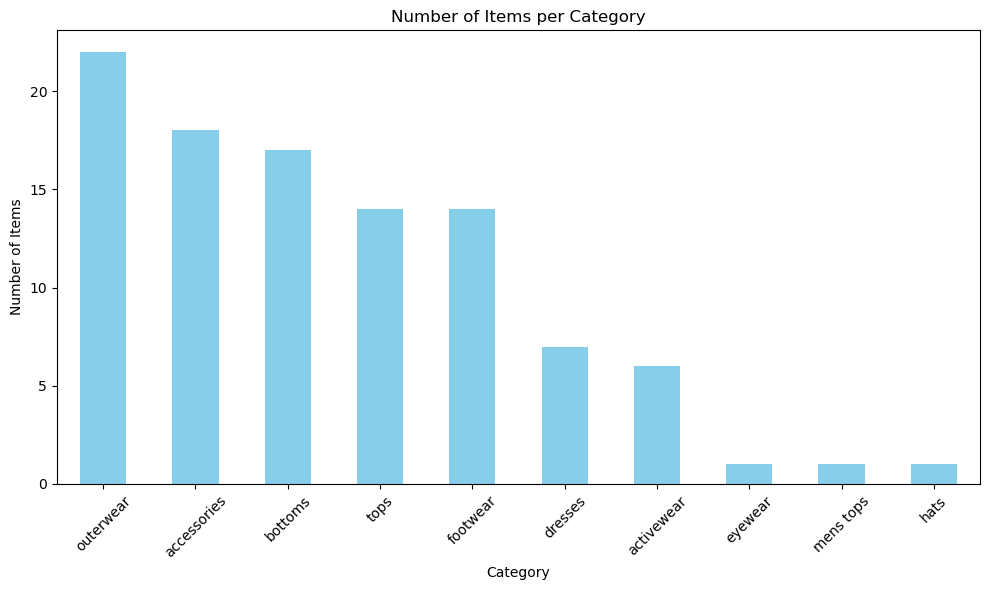

In [6]:
# Count unique values in 'category' column
category_counts = df['category'].value_counts()
# Make a bar plot of the category counts
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Items per Category')
plt.xlabel('Category')
plt.ylabel('Number of Items')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
type(df["tags"].iloc[0])

list

In [20]:
df['tags'].apply(lambda x: [tag.strip("'") for tag in x]).explode().value_counts()

tags
casual             27
sporty             20
elegant            12
tailored           11
vintage            10
                   ..
necklace            1
bohemian            1
flats               1
cap                 1
reflective logo     1
Name: count, Length: 154, dtype: int64

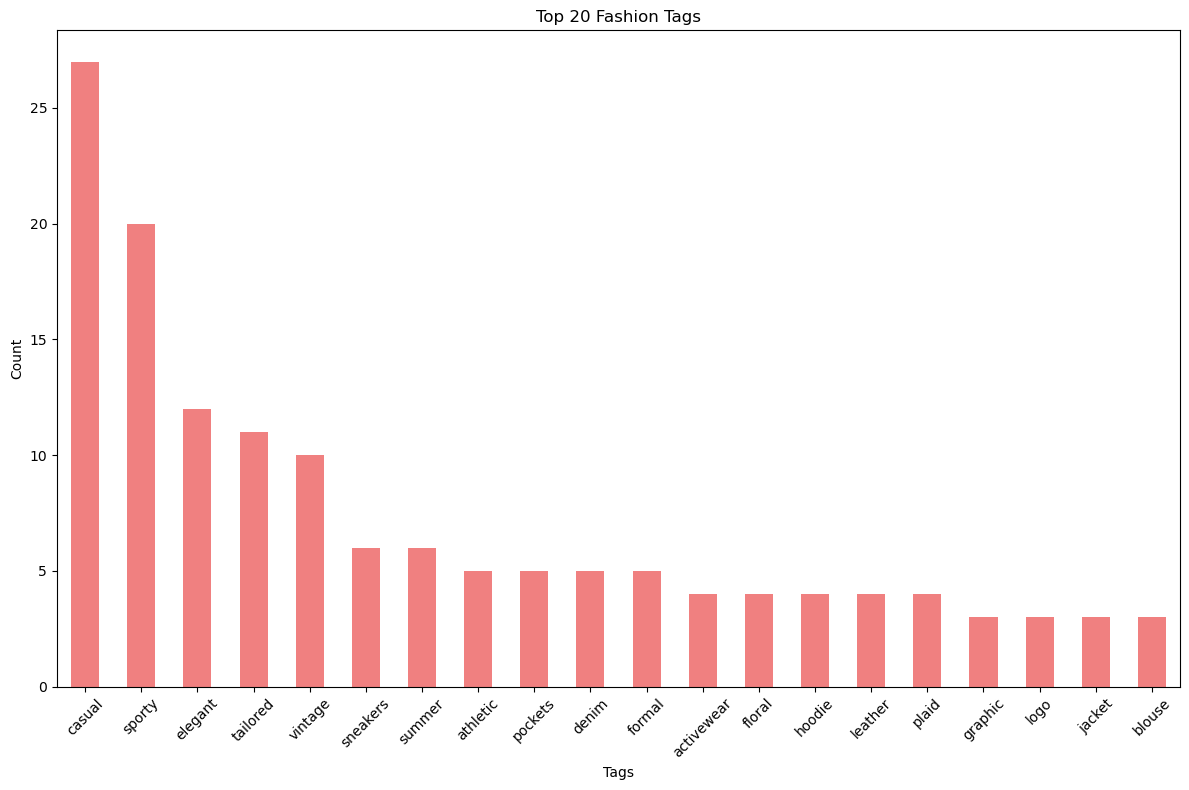

In [22]:
# Count the unique tags in the 'tags' column
# Tags are stored as literal lists in the 'tags' column
tag_counts = df['tags'].apply(lambda x: [tag.strip("'") for tag in x]).explode().value_counts()
# There are a lot of unique tags, so a better way to visualize this is to plot the top 20 tags
top_tags = tag_counts.head(20)
plt.figure(figsize=(12, 8))
top_tags.plot(kind='bar', color='lightcoral')
plt.title('Top 20 Fashion Tags')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
tag_counts 

tags
casual             27
sporty             20
elegant            12
tailored           11
vintage            10
                   ..
necklace            1
bohemian            1
flats               1
cap                 1
reflective logo     1
Name: count, Length: 154, dtype: int64

In [28]:
np.count_nonzero(tag_counts < 2)/len(tag_counts)

np.float64(0.7077922077922078)

This could present a challenge when we get to the recommendation algorithm as there are many tags that are only used by one item. In fact, about 70% of the items have a unique tag (or multiple unique tags). Perhaps we could explore aggregating tags based on category. 

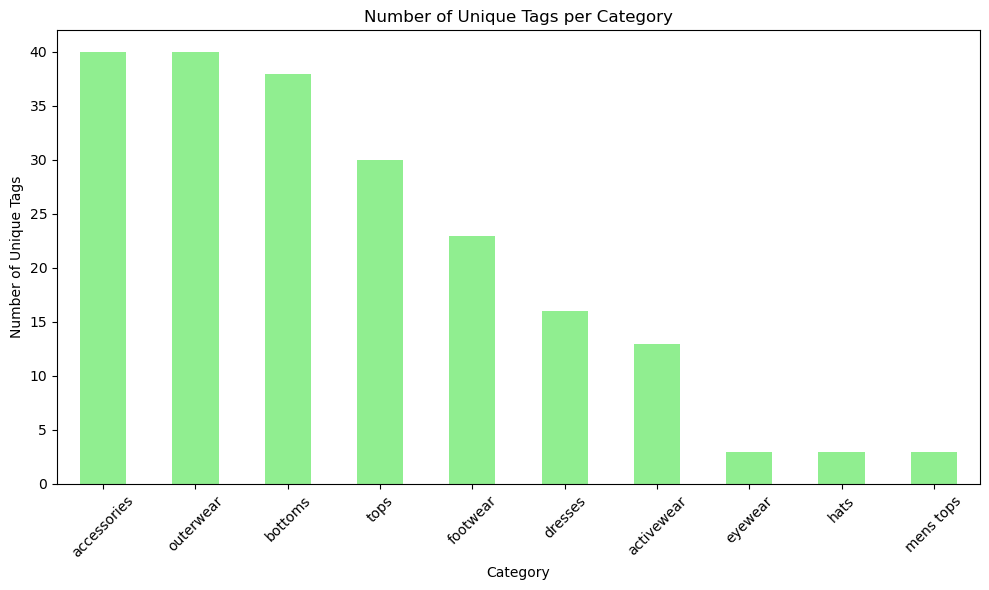

In [30]:
# Number of unique tags per category
unique_tags_per_category = df.groupby('category')['tags'].apply(lambda x: set([tag for sublist in x for tag in sublist])).apply(len)
unique_tags_per_category = unique_tags_per_category.sort_values(ascending=False)
# Plot the number of unique tags per category
plt.figure(figsize=(10, 6))
unique_tags_per_category.plot(kind='bar', color='lightgreen')
plt.title('Number of Unique Tags per Category')
plt.xlabel('Category')
plt.ylabel('Number of Unique Tags')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()  

Eyewear, hats, and mens tops all only have one unique tag. Eyewear could likely be added to accessories, hats to outerwear, and mens tops to tops. But there are still a lot of unique tags in the larger categories, indicating maybe some overlap (e.g. boho and bohemian or blazer and suit). Let's dive into it a little more. 

In [31]:
# Check unique tags for accessories
accessories_tags = df[df['category'] == 'accessories']['tags'].explode().unique()
print("Unique tags in Accessories:", accessories_tags)

Unique tags in Accessories: ['chic' 'handbag' 'leather' 'woven' 'tote' 'summer' 'elegant' 'silk'
 'scarf' 'sporty' 'cap' 'logo' 'bohemian' 'necklace' 'beaded' 'casual'
 'backpack' 'canvas' 'clutch' 'bag' 'vintage' 'sunglasses' 'accessories'
 'baseball cap' 'pearl' 'earrings' 'satchel' 'statement necklace'
 'silk scarf' 'floral' 'athletic cap' 'ventilation' 'leather backpack'
 'buckles' 'athletic socks' 'arch support' 'leather satchel'
 'embossed logo' 'canvas tote bag' 'floral print']


This doesn't seem too bad as far as overlap, but there are definitely some more specific tags that could be perhaps combined, like "canvas tote bag" and "canvas" or even "bag". I'll leave this to later if performance suffers in the recommendation algorithm, but it is interesting to note. 

I'm assuming the titles are all unique, but it could be interesting to see how they relate to the tags. Let's check for words in common between an items title and its tags. 

In [32]:
# Check for same words in title and tags
def common_words(title, tags):
    title_words = set(title.lower().split())
    tag_words = set(tag.lower() for tag in tags)
    return title_words.intersection(tag_words)

df['common_words'] = df.apply(lambda row: common_words(row['title'], row['tags']), axis=1)
# Display items with common words
common_items = df[df['common_words'].apply(len) > 0]
print("Items with common words in title and tags:")
print(common_items[['title', 'tags', 'common_words']].head(10))

Items with common words in title and tags:
                             title                              tags  \
item_id                                                                
0           Boho Summer Maxi Dress             [boho, dress, summer]   
1          Minimalist Linen Blouse    [minimalist, blouse, neutrals]   
2             Vintage Denim Jacket          [vintage, jacket, denim]   
3                Cozy Knit Sweater             [cozy, sweater, fall]   
4        Streetwear Graphic Hoodie       [streetwear, hoodie, urban]   
5             Sustainable Yoga Set   [sustainable, athleisure, yoga]   
6             Classic Black Blazer         [classic, blazer, formal]   
7              Colorblock Sneakers  [sneakers, colorful, streetwear]   
8                Ruffle Mini Skirt         [feminine, skirt, summer]   
9              Utility Cargo Pants      [utility, cargo, functional]   

                     common_words  
item_id                            
0           {dress, 

It does appear that there are many words in common across the first ten product titles and tags. This indicates that perhaps one or the other might be more useful to use rather than both. 

## Users

In [34]:
users = pd.read_csv('../data/fashion_users.csv')
users.set_index('user_id', inplace=True)
users['interests'] = users['interests'].apply(ast.literal_eval)
# Display the first few rows of the users DataFrame
users.head()

,interests
user_id,
0,"[boho, summer, feminine]"
1,"[streetwear, sneakers, urban]"
2,"[minimalist, neutrals, sustainable]"
3,"[vintage, fall, denim]"
4,"[formal, classic, blazer]"


In [53]:
len(users)

51

The users data essentially just maps a user to their interests, which in this use case could come from profiles or directly from the pins they made so far. 

Let's take a look at how many duplicate interests there are. 

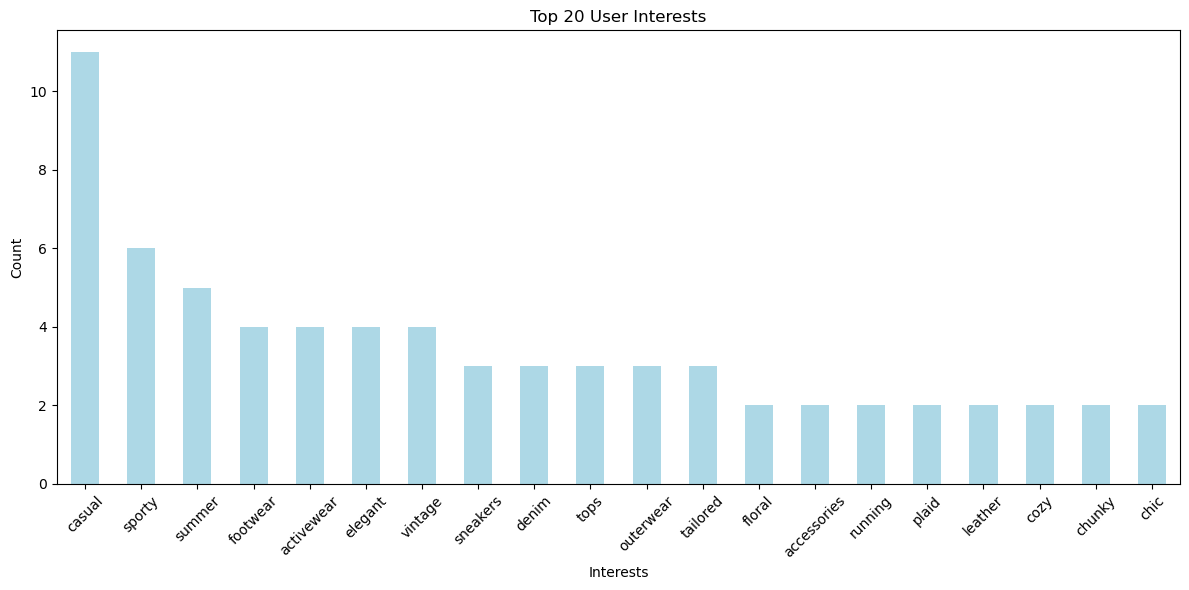

In [37]:
# Create a bar chart of the number of instances of each interest
interest_counts = users['interests'].explode().value_counts()
plt.figure(figsize=(12, 6))
interest_counts.head(20).plot(kind='bar', color='lightblue')
plt.title('Top 20 User Interests')
plt.xlabel('Interests')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

That knd of makes sense, the more general terms like "casual" and "sporty" have higher usage, while the more specific interests like "running" or "plaid" have lower usage. What's interesting to me is that there are some more general terms that are less used, like tops or denim. That could indicate that in the users early usage of the app we don't know what they're looking for (e.g. casual tops or casual denim), only that they pinned more casual or sporty images. 

## Interactions

In [50]:
interactions = pd.read_csv('../data/fashion_interactions.csv')
interactions.head()

,user_id,item_id,liked
0,0,0,1
1,0,8,1
2,0,15,1
3,0,18,1
4,0,36,1


This data models what a user pinned. Let's get a count of pins per user. 

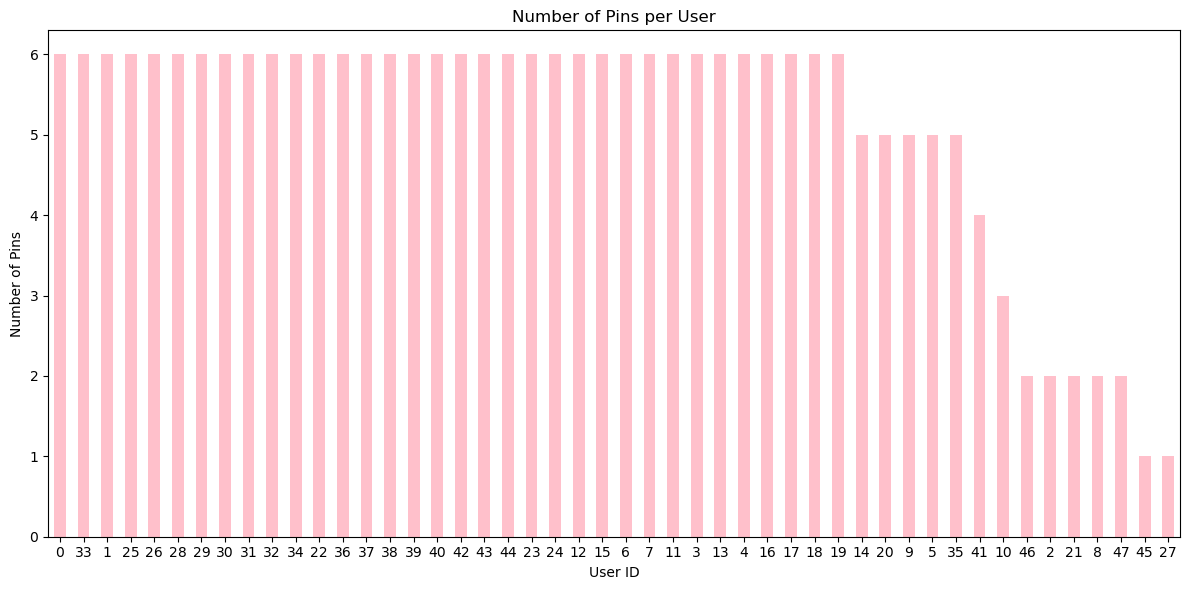

In [51]:
# Count of pins per user
user_pin_counts = interactions['user_id'].value_counts()
plt.figure(figsize=(12, 6))
user_pin_counts.plot(kind='bar', color='pink')
plt.title('Number of Pins per User')
plt.xlabel('User ID')
plt.ylabel('Number of Pins')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [52]:
len(user_pin_counts)

48

Ok, so we can see that most users have 5 pins, while some have fewer. There are also 2 or 3 users that don't have any pins, indicating their interests were built off of other profile features or manually added. 

Let's take one user as an example and see how the items they pinned relate to their interests. 

In [55]:
example_user_id = user_pin_counts.index[0]  # Take the first user as an example
example_user_pins = interactions[interactions['user_id'] == example_user_id]
example_user_items = df.loc[example_user_pins['item_id']]
# Display the example user's pins and their corresponding items
print("The user's interests are:")
print(users.loc[example_user_id, 'interests'])
print("Example User Items:")
print(example_user_items[['title', 'tags']])

The user's interests are:
['boho', 'summer', 'feminine']
Example User Items:
                           title                                tags
item_id                                                             
0         Boho Summer Maxi Dress               [boho, dress, summer]
8              Ruffle Mini Skirt           [feminine, skirt, summer]
15       Floral Print Maxi Skirt              [floral, maxi, summer]
18          Woven Straw Tote Bag               [woven, tote, summer]
36       Floral Print Wrap Dress        [floral, wrap dress, summer]
83       Elegant Silk Wrap Dress  [elegant, silk wrap dress, summer]


It does seem like the users interests match the products they liked. We have several dresses and skirts, relating to summer and feminine. Let's take a look at another user. 

In [56]:
example_user_id = user_pin_counts.index[10]  # Take the first user as an example
example_user_pins = interactions[interactions['user_id'] == example_user_id]
example_user_items = df.loc[example_user_pins['item_id']]
# Display the example user's pins and their corresponding items
print("The user's interests are:")
print(users.loc[example_user_id, 'interests'])
print("Example User Items:")
print(example_user_items[['title', 'tags']])

The user's interests are:
['casual', 'polo shirt', 'smart']
Example User Items:
                                    title                         tags
item_id                                                               
11                  Casual Chambray Shirt       [casual, shirt, denim]
14                Retro High-Top Sneakers    [retro, sneakers, casual]
19                 Classic White Sneakers  [classic, sneakers, casual]
25                   Casual Slip-On Shoes  [casual, slip-on, footwear]
27                         Denim Overalls    [denim, overalls, casual]
29       Vintage-Inspired Mary Jane Flats     [vintage, flats, casual]


Here the user seemed to pin a lot of casual elements, with some relating to their polo shirt interest. To me this doesn't seem like as good of a fit to the interests, but I would expect that would change over time. Looks look at one more, perhaps a user that had less pins. 

In [57]:
example_user_id = user_pin_counts.index[-1]  # Take the first user as an example
example_user_pins = interactions[interactions['user_id'] == example_user_id]
example_user_items = df.loc[example_user_pins['item_id']]
# Display the example user's pins and their corresponding items
print("The user's interests are:")
print(users.loc[example_user_id, 'interests'])
print("Example User Items:")
print(example_user_items[['title', 'tags']])

The user's interests are:
['bohemian', 'necklace', 'trending']
Example User Items:
                            title                          tags
item_id                                                        
30       Bohemian Beaded Necklace  [bohemian, necklace, beaded]


In this case the user only has one pin, but it seems to fit their interests quite well in terms of it being a boho necklace. 